In [69]:
import yfinance as yf
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
tickerData = yf.Ticker("VZ")

tickerDf = tickerData.history(period='1y', interval='1d')

tickerClose = tickerDf.Close

daily_returns = tickerClose

print(daily_returns)


Date
2023-05-08 00:00:00-04:00    35.214294
2023-05-09 00:00:00-04:00    34.972275
2023-05-10 00:00:00-04:00    35.028126
2023-05-11 00:00:00-04:00    35.000198
2023-05-12 00:00:00-04:00    34.990891
                               ...    
2024-05-02 00:00:00-04:00    38.930000
2024-05-03 00:00:00-04:00    38.889999
2024-05-06 00:00:00-04:00    39.330002
2024-05-07 00:00:00-04:00    39.310001
2024-05-08 00:00:00-04:00    39.483601
Name: Close, Length: 253, dtype: float64


In [71]:
daily_returns.index = pd.to_datetime(daily_returns.index)
daily_returns.index = (daily_returns.index - daily_returns.index[0]).days

min_day = daily_returns.index.min()
max_day = daily_returns.index.max()

print(daily_returns)
normalized_index = (daily_returns.index - min_day) / (max_day - min_day)

daily_returns.index = normalized_index

daily_returns

Date
0      35.214294
1      34.972275
2      35.028126
3      35.000198
4      34.990891
         ...    
360    38.930000
361    38.889999
364    39.330002
365    39.310001
366    39.483601
Name: Close, Length: 253, dtype: float64


Date
0.000000    35.214294
0.002732    34.972275
0.005464    35.028126
0.008197    35.000198
0.010929    34.990891
              ...    
0.983607    38.930000
0.986339    38.889999
0.994536    39.330002
0.997268    39.310001
1.000000    39.483601
Name: Close, Length: 253, dtype: float64

[Text(0.5, 1.0, 'y train-test split '), Text(0.5, 0, 't'), Text(0, 0.5, '')]

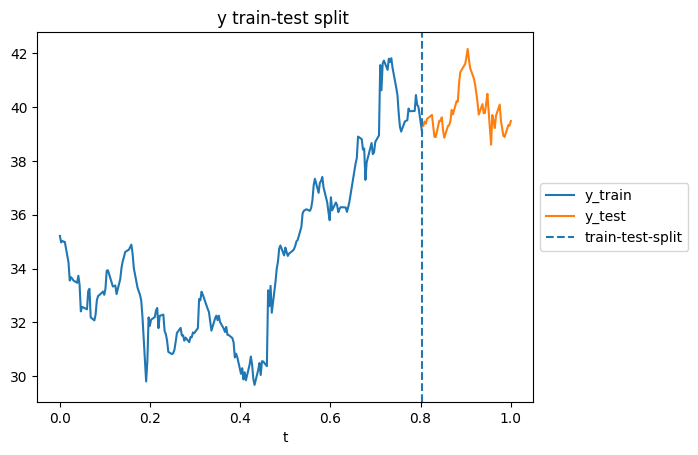

In [212]:
x = daily_returns.index.values.T
y = daily_returns.values.T
n = len(daily_returns)

prop_train = 0.8
n_train = round(prop_train * n)

x_train = x[:n_train]
y_train = y[:n_train]

x_test = x[n_train:]
y_test = y[n_train:]

# Plot.
fig, ax = plt.subplots()
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), label='y_train', ax=ax)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), label='y_test', ax=ax)
ax.axvline(x=x_train.flatten()[-1], linestyle='--', label='train-test-split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='y train-test split ', xlabel='t', ylabel='')

In [74]:
with pm.Model() as model:

    l_ratquad = pm.HalfNormal('l_ratquad', sigma=1)
    alpha_ratquad = pm.HalfNormal('alpha_ratquad', sigma=1)
    sigma_ratquad = pm.HalfNormal('sigma_ratquad', sigma=1)

    l_matern32 = pm.HalfNormal('l_matern32', sigma=1)
    sigma_matern32 = pm.HalfNormal('sigma_matern32', sigma=1)

    cov_ratquad = sigma_ratquad * pm.gp.cov.RatQuad(1, l_ratquad, alpha_ratquad)
    cov_matern32 = sigma_matern32 * pm.gp.cov.Matern32(1, l_matern32)

    cov = cov_ratquad + cov_matern32

    a = pm.Normal("a",0,1)
    b = pm.Normal("b",0.5,0.05)
    trend = pm.Deterministic("trend",a + b*x_train)
    M = pm.gp.mean.Linear([b],a)

    gp = pm.gp.Marginal(mean_func=M, cov_func=cov)
    sigma = pm.HalfNormal('sigma', sigma=1)
    y_obs = gp.marginal_likelihood('y', X=x_train.reshape(-1,1),y=y_train, noise=sigma)


/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [ ]:
with model:
  prior = pm.sample_prior_predictive()

In [ ]:
prior

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

<ipython-input-7-eb70643cfcc9>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]
<ipython-input-7-eb70643cfcc9>:13: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior, group="prior", num_samples=100)["trend"] * y_train.max(),


Text(0.5, 1.0, 'Prior trend lines')

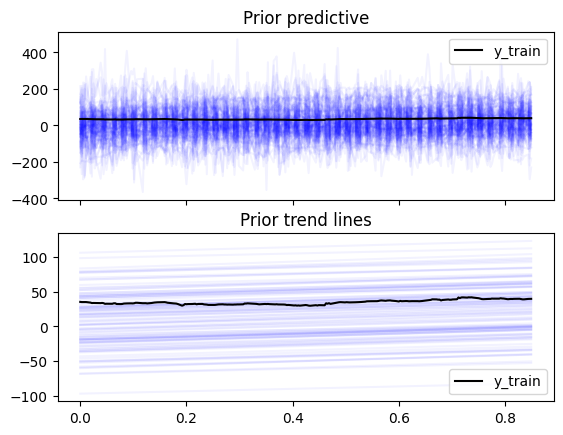

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    x_train,
    az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]
    * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k", label='y_train', ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    x_train,
    az.extract_dataset(prior, group="prior", num_samples=100)["trend"] * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k",label='y_train', ax=ax[1])
ax[1].set_title("Prior trend lines")

In [105]:
with pm.Model() as model:

    l_ratquad = pm.HalfNormal('l_ratquad', sigma=4)
    alpha_ratquad = pm.HalfNormal('alpha_ratquad', sigma=4)
    sigma_ratquad = pm.HalfNormal('sigma_ratquad', sigma=4)

    l_matern32 = pm.HalfNormal('l_matern32', sigma=0.1)
    sigma_matern32 = pm.HalfNormal('sigma_matern32', sigma=0.1)

    cov_ratquad = sigma_ratquad * pm.gp.cov.RatQuad(1, l_ratquad, alpha_ratquad)
    cov_matern32 = sigma_matern32 * pm.gp.cov.Matern32(1, l_matern32)

    cov = cov_ratquad + cov_matern32

    a = pm.Normal("a",0,1)
    b = pm.Normal("b",0,0.125)
    trend = pm.Deterministic("trend",a + b*x_train)
    M = pm.gp.mean.Linear([b],a)

    gp = pm.gp.Marginal(mean_func=M, cov_func=cov)
    sigma = pm.HalfNormal('sigma', sigma=1)
    y_obs = gp.marginal_likelihood('y', X=x_train.reshape(-1,1),y=y_train, noise=sigma)


/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [ ]:
with model:
  prior = pm.sample_prior_predictive()

<ipython-input-11-eb70643cfcc9>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]
<ipython-input-11-eb70643cfcc9>:13: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior, group="prior", num_samples=100)["trend"] * y_train.max(),


Text(0.5, 1.0, 'Prior trend lines')

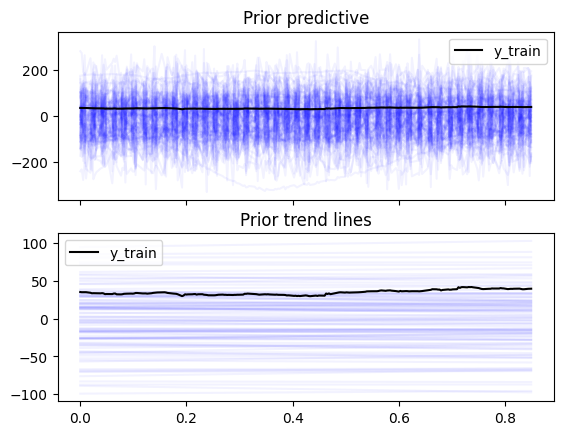

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    x_train,
    az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]
    * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k", label='y_train', ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    x_train,
    az.extract_dataset(prior, group="prior", num_samples=100)["trend"] * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k",label='y_train', ax=ax[1])
ax[1].set_title("Prior trend lines")

In [ ]:
with model:
  trace_approx = pm.fit()
  trace = trace_approx.sample()

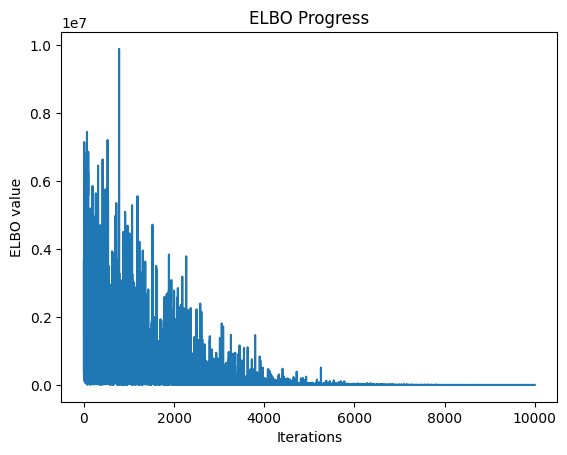

In [ ]:
plt.plot(trace_approx.hist)
plt.title('ELBO Progress')
plt.xlabel('Iterations')
plt.ylabel('ELBO value')
plt.show()

In [ ]:
with model:
    x_test_c = gp.conditional('x_test', x_test.reshape(-1,1))
    pred_m = pm.sample_posterior_predictive(trace, var_names=["x_test"])

In [ ]:
pred_m

Inference data with groups:
	> posterior_predictive
	> observed_data

<ipython-input-34-de5a17511722>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(pred_m, group="posterior_predictive", num_samples=200)["x_test"],


Text(0.5, 1.0, 'Posterior predictive')

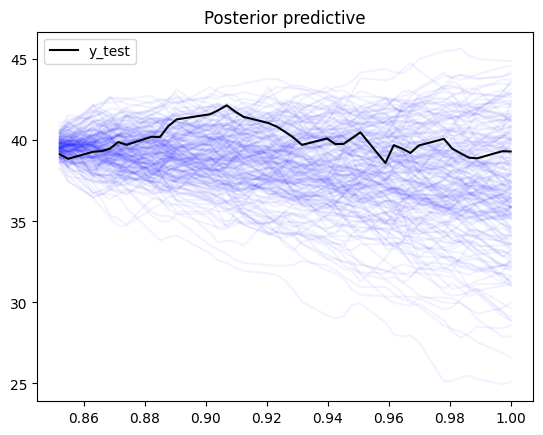

In [ ]:
fig, ax = plt.subplots()
ax.plot(
    x_test,
    az.extract_dataset(pred_m, group="posterior_predictive", num_samples=200)["x_test"],
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), color="k", label='y_test', ax=ax)
ax.set_title("Posterior predictive")

In [ ]:
with pm.Model() as model_2:

    l_ratquad = pm.HalfNormal('l_ratquad', sigma=1)
    alpha_ratquad = pm.HalfNormal('alpha_ratquad', sigma=1)
    sigma_ratquad = pm.HalfNormal('sigma_ratquad', sigma=1)

    l_expquad = pm.HalfNormal('l_expquad', sigma=2)
    sigma_expquad = pm.HalfNormal('sigma_expquad', sigma=2)
    cov_expquad = sigma_expquad * pm.gp.cov.ExpQuad(1, l_expquad)

    l_matern32 = pm.HalfNormal('l_matern32', sigma=0.5)
    sigma_matern32 = pm.HalfNormal('sigma_matern32', sigma=0.5)

    cov_ratquad = sigma_ratquad * pm.gp.cov.RatQuad(1, l_ratquad, alpha_ratquad)
    cov_matern32 = sigma_matern32 * pm.gp.cov.Matern32(1, l_matern32)

    cov = cov_ratquad + cov_matern32 + cov_expquad

    gp = pm.gp.Marginal(cov_func=cov)
    sigma = pm.HalfNormal('sigma', sigma=1)
    wn = pm.gp.cov.WhiteNoise(sigma)

    y_obs = gp.marginal_likelihood('y', X=x_train.reshape(-1,1),y=y_train, noise=wn)


/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [ ]:
with model:
  prior = pm.sample_prior_predictive()

<ipython-input-43-1fd1bb1ae432>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]


Text(0.5, 1.0, 'Prior predictive')

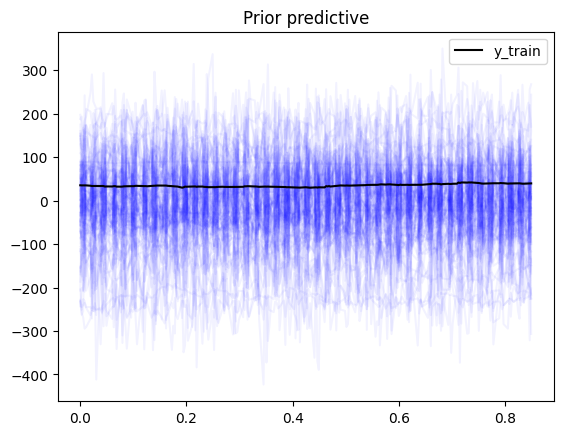

In [ ]:
fig, ax = plt.subplots()
ax.plot(
    x_train,
    az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]
    * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k", label='y_train', ax=ax)
ax.set_title("Prior predictive")

In [ ]:
with model_2:
  trace_approx_2 = pm.fit()
  trace_2 = trace_approx_2.sample()

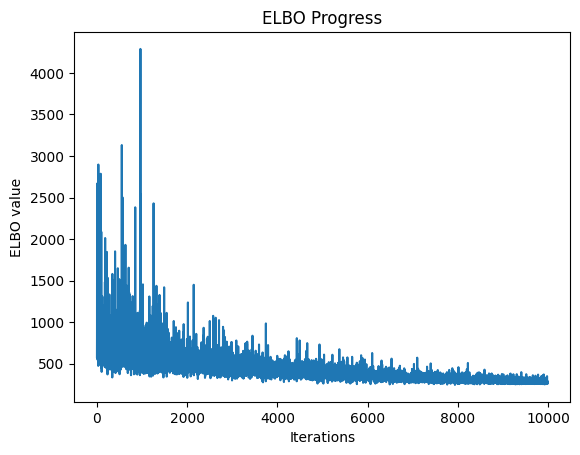

In [ ]:
plt.plot(trace_approx_2.hist)
plt.title('ELBO Progress')
plt.xlabel('Iterations')
plt.ylabel('ELBO value')
plt.show()

In [ ]:
with model_2:
    x_test_c = gp.conditional('x_test', x_test.reshape(-1,1))
    pred_m_2 = pm.sample_posterior_predictive(trace_2, var_names=["x_test"])

<ipython-input-47-2d2c3d0b8cf7>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(pred_m_2, group="posterior_predictive", num_samples=200)["x_test"],


Text(0.5, 1.0, 'Posterior predictive')

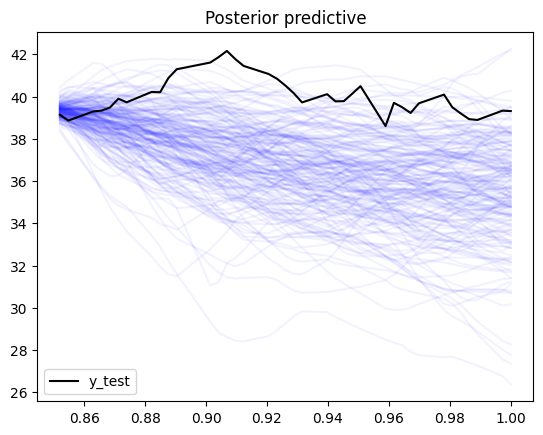

In [ ]:
fig, ax = plt.subplots()
ax.plot(
    x_test,
    az.extract_dataset(pred_m_2, group="posterior_predictive", num_samples=200)["x_test"],
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), color="k", label='y_test', ax=ax)
ax.set_title("Posterior predictive")

In [164]:
import pytensor.tensor as tt
class PiecewiseLinear(pm.gp.mean.Mean):
    def __init__(self, breakpoint, intercept, slope1, slope2):
        super().__init__()
        self.breakpoint = breakpoint
        self.intercept = intercept
        self.slope1 = slope1
        self.slope2 = slope2
        self.trend = list()

    def __call__(self, X):
        X1 = X.flatten()
        trend = tt.switch(X1 < self.breakpoint,
                         self.intercept + self.slope1 * X1,
                         self.intercept + self.slope1 * self.breakpoint + self.slope2 * (X1 - self.breakpoint))
        #pm.Deterministic("trend",trend)
        return trend


In [165]:
with pm.Model() as model_3:

    l_ratquad = pm.HalfNormal('l_ratquad', sigma=4)
    alpha_ratquad = pm.HalfNormal('alpha_ratquad', sigma=4)
    sigma_ratquad = pm.HalfNormal('sigma_ratquad', sigma=4)

    l_matern32 = pm.HalfNormal('l_matern32', sigma=0.1)
    sigma_matern32 = pm.HalfNormal('sigma_matern32', sigma=0.1)

    cov_ratquad = sigma_ratquad * pm.gp.cov.RatQuad(1, l_ratquad, alpha_ratquad)
    cov_matern32 = sigma_matern32 * pm.gp.cov.Matern32(1, l_matern32)

    cov = cov_ratquad + cov_matern32

    bp = pm.Normal('breakpoint', mu=0.4, sigma=0.1)
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    slope1 = pm.Normal('slope1', mu=-1, sigma=1)
    slope2 = pm.Normal('slope2', mu=1, sigma=1)
    M = PiecewiseLinear(bp,intercept,slope1,slope2)

    gp = pm.gp.Marginal(mean_func=M, cov_func=cov)
    sigma = pm.HalfNormal('sigma', sigma=1)
    y_obs = gp.marginal_likelihood('y', X=x_train.reshape(-1,1),y=y_train, noise=sigma)


/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [159]:
with model_3:
  prior = pm.sample_prior_predictive()

In [160]:
prior

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

<ipython-input-161-eb70643cfcc9>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]
<ipython-input-161-eb70643cfcc9>:13: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior, group="prior", num_samples=100)["trend"] * y_train.max(),


Text(0.5, 1.0, 'Prior trend lines')

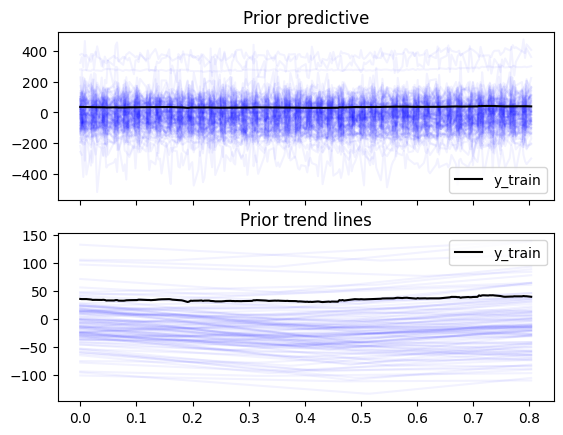

In [161]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    x_train,
    az.extract_dataset(prior, group="prior_predictive", num_samples=100)["y"]
    * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k", label='y_train', ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    x_train,
    az.extract_dataset(prior, group="prior", num_samples=100)["trend"] * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k",label='y_train', ax=ax[1])
ax[1].set_title("Prior trend lines")

In [162]:
with model_3:
  trace_approx_3 = pm.fit()
  trace_3 = trace_approx_3.sample()

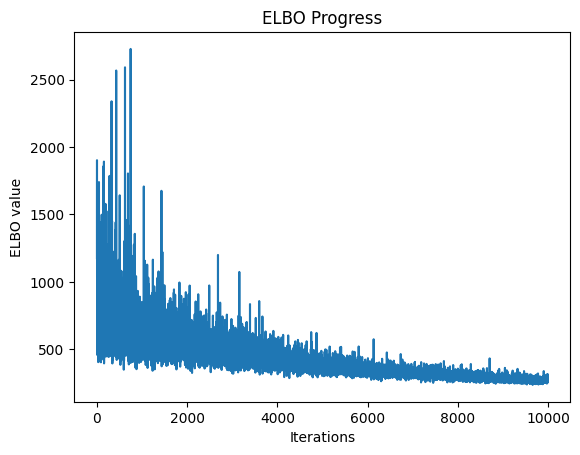

In [170]:
plt.plot(trace_approx_3.hist)
plt.title('ELBO Progress')
plt.xlabel('Iterations')
plt.ylabel('ELBO value')
plt.show()

In [163]:
pm.summary(trace_3)

Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
breakpoint,0.354,0.123,0.118,0.566,0.006,0.004,459.0,515.0,NaN
intercept,1.860,0.990,0.070,3.822,0.045,0.032,495.0,472.0,NaN
slope1,-0.965,0.970,-2.677,0.887,0.042,0.030,543.0,430.0,NaN
slope2,2.590,0.956,0.942,4.394,0.041,0.030,550.0,474.0,NaN
l_ratquad,1.117,1.448,0.015,3.036,0.063,0.044,465.0,439.0,NaN
...,...,...,...,...,...,...,...,...,...
trend[197],2.638,1.190,0.413,4.790,0.054,0.038,492.0,492.0,NaN
trend[198],2.645,1.191,0.415,4.796,0.054,0.038,491.0,492.0,NaN
trend[199],2.652,1.191,0.418,4.803,0.054,0.038,491.0,492.0,NaN
trend[200],2.659,1.192,0.421,4.810,0.054,0.038,492.0,492.0,NaN


In [166]:
with model_3:
    x_test_c = gp.conditional('x_test', x_test.reshape(-1,1))
    pred_m_3 = pm.sample_posterior_predictive(trace_3, var_names=["x_test"])

<ipython-input-167-2911012fecb0>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(pred_m_3, group="posterior_predictive", num_samples=200)["x_test"],


Text(0.5, 1.0, 'Posterior predictive')

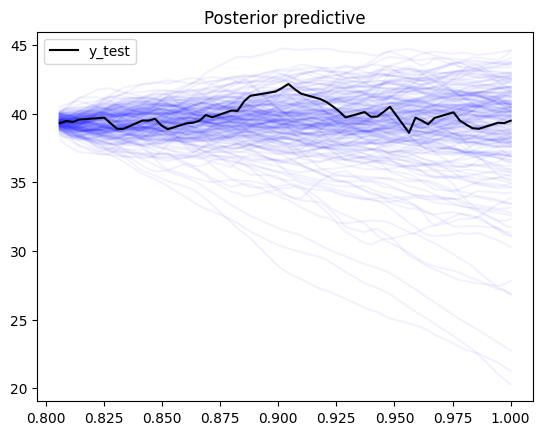

In [167]:
fig, ax = plt.subplots()
ax.plot(
    x_test,
    az.extract_dataset(pred_m_3, group="posterior_predictive", num_samples=200)["x_test"],
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), color="k", label='y_test', ax=ax)
ax.set_title("Posterior predictive")

In [174]:
f_pred_samples = az.extract(pred_m_3, group="posterior_predictive", var_names=["x_test"])
f_pred_samples

<xarray.DataArray 'x_test' (x_test_dim_2: 51, sample: 500)>
array([[39.11127287, 39.09823514, 40.01584212, ..., 40.49167196,
        39.32354464, 39.79878935],
       [38.99130583, 39.05908288, 40.1205152 , ..., 40.66859913,
        39.28286422, 39.85256007],
       [38.97302099, 39.08426096, 40.21790415, ..., 40.83163846,
        39.14585257, 39.96493043],
       ...,
       [37.12105271, 39.01423636, 42.71608183, ..., 40.70915512,
        40.30713588, 38.96871896],
       [37.18105784, 38.9771395 , 42.70850468, ..., 40.76623183,
        40.42001833, 38.6744872 ],
       [37.22957927, 38.9060209 , 42.79981948, ..., 40.83467191,
        40.58959327, 38.47719413]])
Coordinates:
  * x_test_dim_2  (x_test_dim_2) int64 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
  * sample        (sample) object MultiIndex
  * chain         (sample) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
  * draw          (sample) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499

<Axes: >

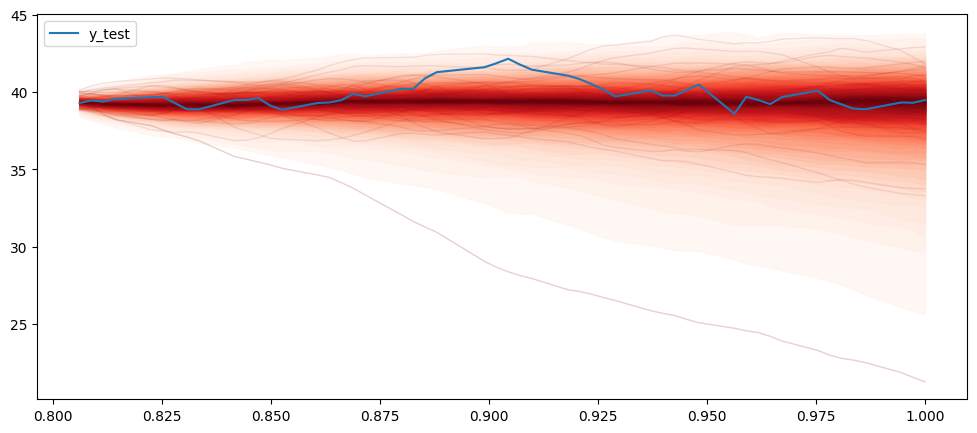

In [175]:
from pymc.gp.util import plot_gp_dist

fig = plt.figure(figsize=(12,5)); ax = fig.gca()

plot_gp_dist(ax, f_pred_samples.T, x_test);

sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), label='y_test', ax=ax)

In [195]:
y_pred = pred_m_3.posterior_predictive["x_test"].values.mean(axis=1)[0]
print(f"MAE: {abs(y_pred - y_test).sum()/len(y_test)}")

MAE: 0.8522827777590437


O modelo acima propõe que, em média, há uma diferença de $0.85 no preço diário (predição) de acordo com os dados de teste.

# O modelo Prophet (Meta)

O modelo Prophet, desenvolvido pelo Facebook, é amplamente utilizado para previsão de séries temporais, especialmente útil para dados com padrões sazonais claros e feriados, ou eventos que não seguem uma periodicidade regular. Ele é robusto a dados faltantes e mudanças na tendência, e funciona bem com séries temporais que têm variações sazonais fortes e históricos de vários anos.

O modelo Prophet separa a série temporal em três componentes principais:

Tendência (Trend): Representa a componente que modela as mudanças não periódicas e de longo prazo na série temporal.
Sazonalidade (Seasonality): Modela os padrões periódicos que se repetem regularmente, como sazonalidade diária, semanal, mensal, ou anual.
Feriados e Eventos (Holidays and Events): São componentes que modelam irregularidades que não seguem um padrão fixo, como feriados ou eventos especiais que podem ter efeitos sobre a série temporal.

A fórmula é dada por:

A fórmula usada pelo Prophet para modelar uma série temporal y(t) é expressa como:
$y(t)=g(t)+s(t)+h(t)+ ɛ$

onde:
- g(t) representa a função de tendência, que modela mudanças não periódicas na série temporal.
- s(t) representa a função de sazonalidade, capturando padrões periódicos dentro dos dados.
- h(t) representa os efeitos de feriados e eventos específicos.
- ɛ é o termo de erro, assumindo que os resíduos dos dados são normalmente distribuídos.

In [200]:
with pm.Model() as prophet:
    X = pm.MutableData("X",x_train)
    y = pm.MutableData("y",y_train)

    bp = pm.Normal('breakpoint', mu=0.4, sigma=0.1)
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    slope1 = pm.Normal('slope1', mu=-1, sigma=1)
    slope2 = pm.Normal('slope2', mu=1, sigma=1)

    trend = tt.switch(X < bp,
              intercept + slope1 * X,
              intercept + slope1 * bp + slope2 * (X - bp))

    trend = pm.Deterministic("trend", trend)

    σ = pm.HalfNormal("σ", sigma=1)
    pm.Normal("likelihood", mu=trend, sigma=σ, observed=y)

In [201]:
with prophet:
  p_prior = pm.sample_prior_predictive()

<ipython-input-220-072e78c728ae>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(p_prior, group="prior_predictive", num_samples=100)["likelihood"]
<ipython-input-220-072e78c728ae>:13: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(p_prior, group="prior", num_samples=100)["trend"] * y_train.max(),


Text(0.5, 1.0, 'Prior trend lines')

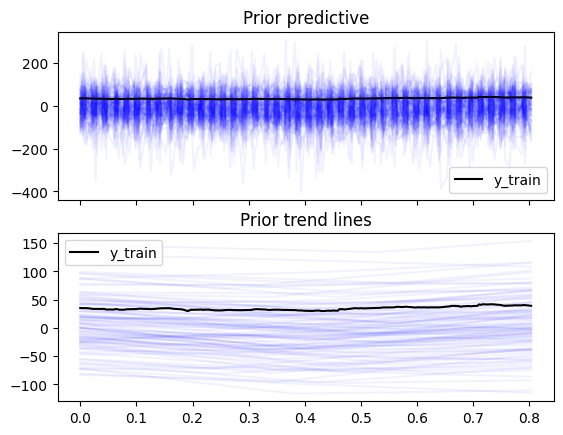

In [220]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    x_train,
    az.extract_dataset(p_prior, group="prior_predictive", num_samples=100)["likelihood"]
    * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k", label='y_train', ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    x_train,
    az.extract_dataset(p_prior, group="prior", num_samples=100)["trend"] * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k",label='y_train', ax=ax[1])
ax[1].set_title("Prior trend lines")

In [203]:
with prophet:
  trace = pm.sample()

In [204]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
breakpoint,-1.120,0.055,-1.232,-1.021,0.001,0.001,1425.0,1019.0,1.0
intercept,7.653,1.024,5.698,9.613,0.025,0.018,1631.0,1129.0,1.0
slope1,-9.539,0.789,-11.029,-8.089,0.020,0.014,1506.0,1223.0,1.0
slope2,10.473,0.507,9.587,11.518,0.014,0.010,1283.0,1117.0,1.0
σ,2.280,0.110,2.074,2.479,0.003,0.002,1819.0,1285.0,1.0
...,...,...,...,...,...,...,...,...,...
trend[197],38.289,0.261,37.810,38.776,0.006,0.005,1685.0,1318.0,1.0
trend[198],38.318,0.262,37.837,38.808,0.006,0.005,1682.0,1318.0,1.0
trend[199],38.346,0.263,37.863,38.841,0.006,0.005,1680.0,1318.0,1.0
trend[200],38.375,0.264,37.893,38.874,0.006,0.005,1678.0,1317.0,1.0


In [207]:
vars = {}
vars["X"] = x_test
vars["y"] = y_test


In [208]:
with prophet:
  pm.set_data(vars)
  trace_post = pm.sample_posterior_predictive(trace)

<ipython-input-210-5df348782b4b>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(trace_post, group="posterior_predictive", num_samples=200)["likelihood"],


Text(0.5, 1.0, 'Posterior predictive')

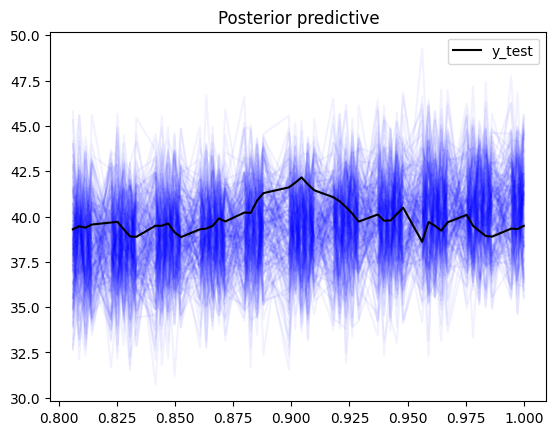

In [210]:
fig, ax = plt.subplots()
ax.plot(
    x_test,
    az.extract_dataset(trace_post, group="posterior_predictive", num_samples=200)["likelihood"],
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), color="k", label='y_test', ax=ax)
ax.set_title("Posterior predictive")

In [255]:
n_order = 3
def get_fourier(n_points,periods):

  x_f = np.linspace(0, periods, n_points)

  fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * x_f / periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
  )

  return fourier_features

In [247]:
coords = {"fourier_features": np.arange(2 * n_order)}
coords

{'fourier_features': array([0, 1, 2, 3, 4, 5])}

In [260]:
with pm.Model(coords=coords) as prophet_p:
    X = pm.MutableData("X",x_train)
    y = pm.MutableData("y",y_train)
    n = X.eval().shape[0]
    fs = get_fourier(n,52)
    fourier_f = pm.MutableData("f_f",fs)

    bp = pm.Normal('breakpoint', mu=0.4, sigma=0.1)
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    slope1 = pm.Normal('slope1', mu=-1, sigma=1)
    slope2 = pm.Normal('slope2', mu=1, sigma=1)

    β_fourier = pm.Normal("β_fourier", mu=0, sigma=1, dims="fourier_features")
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(β_fourier, fourier_f.T)
    )

    trend = tt.switch(X < bp,
              intercept + slope1 * X,
              intercept + slope1 * bp + slope2 * (X - bp))

    trend = pm.Deterministic("trend", trend)

    μ = trend * (1 + seasonality)

    σ = pm.HalfNormal("σ", sigma=1)
    pm.Normal("likelihood", mu=μ, sigma=σ, observed=y)

In [261]:
with prophet_p:
  p_prior_p = pm.sample_prior_predictive()

<ipython-input-262-b4ca3317d2ba>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(p_prior_p, group="prior_predictive", num_samples=100)["likelihood"]
<ipython-input-262-b4ca3317d2ba>:13: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(p_prior_p, group="prior", num_samples=100)["trend"] * y_train.max(),
<ipython-input-262-b4ca3317d2ba>:21: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(p_prior_p, group="prior", num_samples=100)["seasonality"]


Text(0.5, 1.0, 'Prior seasonality')

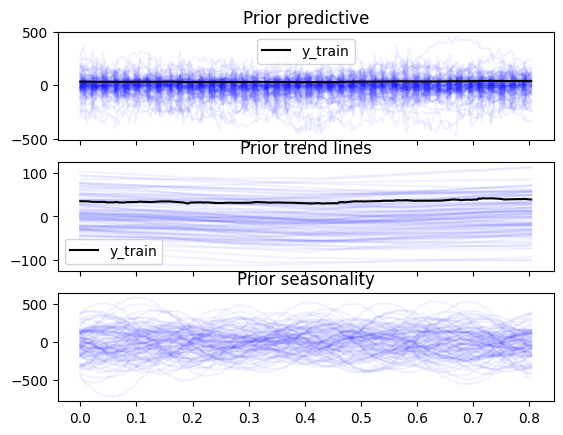

In [262]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)
ax[0].plot(
    x_train,
    az.extract_dataset(p_prior_p, group="prior_predictive", num_samples=100)["likelihood"]
    * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k", label='y_train', ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    x_train,
    az.extract_dataset(p_prior_p, group="prior", num_samples=100)["trend"] * y_train.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color="k",label='y_train', ax=ax[1])
ax[1].set_title("Prior trend lines")
ax[2].plot(
    x_train,
    az.extract_dataset(p_prior_p, group="prior", num_samples=100)["seasonality"]
    * 100,
    color="blue",
    alpha=0.05,
)
ax[2].set_title("Prior seasonality")

In [263]:
with prophet_p:
  trace_p_p = pm.sample()

In [264]:
n_test = x_test.shape[0]
vars["f_f"] = get_fourier(n_test,52)
with prophet_p:
  pm.set_data(vars)
  trace_post_p = pm.sample_posterior_predictive(trace_p_p)

<ipython-input-265-c6da0801c93c>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(trace_post_p, group="posterior_predictive", num_samples=200)["likelihood"],


Text(0.5, 1.0, 'Posterior predictive')

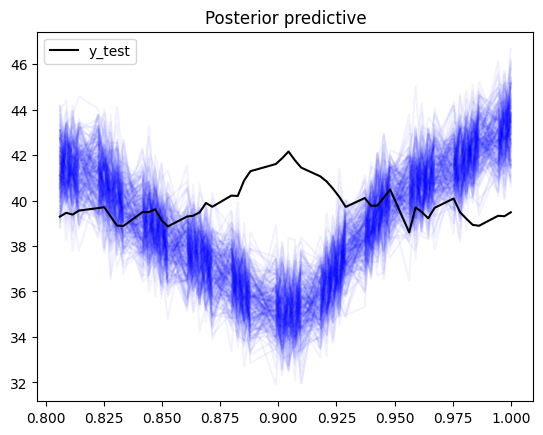

In [265]:
fig, ax = plt.subplots()
ax.plot(
    x_test,
    az.extract_dataset(trace_post_p, group="posterior_predictive", num_samples=200)["likelihood"],
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), color="k", label='y_test', ax=ax)
ax.set_title("Posterior predictive")

# Exercícios

1) Ajustar o modelo acima de modo a reverter a tendência sazonal do ticker VZ.

2) Escolher outro ticker e rodar modelos de GP e do Prophet fazendo comparações.